In [1]:
import datetime
import h5py
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader
from tqdm import trange

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [39]:
raw = h5py.File(os.getcwd() + '/train_data_format1_week_final.h5', 'r')

data = {}
for type in ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT']:
    temp = raw[type + '.csv']
    data[type] = pd.DataFrame(data=temp['block0_values'][()],
                              columns=pd.Series(temp['axis0'][()]).apply(lambda x: str(x, encoding="utf8")).values,
                              index=temp['axis1'][()])
    data[type]['Target'] = data[type]['Close'].pct_change().shift(-1)
    data[type] = data[type][:-1]
    data[type]['tic'] = type

train = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'tic', 'Target'])

for type in ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT']:
    train = pd.concat([train, data[type]], axis=0)

train.reset_index(inplace=True)
train.columns = ['date', 'Open', 'High', 'Low', 'close', 'Volume', 'tic', 'Target']
train.sort_values(by=['date', 'tic'], inplace=True)
train.date = pd.Series(train.date).apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1000000000).strftime('%Y-%m-%d %H:%M:%S'))
train = train[train.date != '2020-12-21 22:09:00']

In [40]:
train_list = []

for i in range(round(len(train)/60)):
    train_list.append((train.iloc[i: 60+i, 1:6].values, train.iloc[60+i: 60+1+i, 7].values))

In [41]:
raw_validation = h5py.File(os.getcwd() + '/eval_data_format1_week_final.h5', 'r')

data_validation = {}
for type in ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT']:
    temp = raw_validation[type + '.csv']
    data_validation[type] = pd.DataFrame(data=temp['block0_values'][()],
                              columns=pd.Series(temp['axis0'][()]).apply(lambda x: str(x, encoding="utf8")).values,
                              index=temp['axis1'][()])
    data_validation[type]['Target'] = data_validation[type]['Close'].pct_change().shift(-1)
    data_validation[type] = data_validation[type][:-1]
    data_validation[type]['tic'] = type

validation = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'tic', 'Target'])

for type in ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT']:
    validation = pd.concat([validation, data_validation[type]], axis=0)

validation.reset_index(inplace=True)
validation.columns = ['date', 'Open', 'High', 'Low', 'close', 'Volume', 'tic', 'Target']
validation.sort_values(by=['date', 'tic'], inplace=True)
validation.date = pd.Series(validation.date).apply(
    lambda x: datetime.datetime.fromtimestamp(x / 1000000000).strftime('%Y-%m-%d %H:%M:%S'))

In [42]:
validation_list = []

for i in range(round(len(validation)/60)):
    validation_list.append((validation.iloc[i: 60+i, 1:6].values, validation.iloc[60+i: 60+1+i, 7].values))

In [55]:
LEARNING_RATE = 0.005
EPOCHS        = 50
BATCH_SIZE    = 150
HIDDEN_SIZE   = 50
DROPOUT       = 0.1
NUM_LAYERS    = 3

OUTPUT_SIZE   = 1
NUM_FEATURES  = 5

params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True,
          'num_workers': 4}

In [56]:
training_dl = DataLoader(train_list, **params)
validation_dl = DataLoader(validation_list, **params)

In [57]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, directions=1):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

model = LSTM(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [58]:
training_losses = []
validation_losses = []


model.train()

for epoch in trange(EPOCHS):
    
    # Initialize hidden and cell states with dimension:
    # (num_layers * num_directions, batch, hidden_size)
    states = model.init_hidden_states(BATCH_SIZE)
    running_training_loss = 0.0
    
    # Begin training
    for idx, (x_batch, y_batch) in enumerate(training_dl):
        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        # Truncated Backpropagation
        states = [state.detach() for state in states]          

        optimizer.zero_grad()

        # Make prediction
        output, states = model(x_batch, states)

        # Calculate loss
        loss = criterion(output[:, -1, :], y_batch)
        loss.backward()
        running_training_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    # Average loss across timesteps
    training_losses.append(running_training_loss / len(training_dl))
    
    if epoch % 2 == 0:
        model.eval()
        
        with torch.no_grad():
            validation_states = model.init_hidden_states(BATCH_SIZE)
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(validation_dl):
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)

                validation_states = [state.detach() for state in validation_states]
                output, validation_states = model(x_batch, validation_states)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()

    validation_losses.append(running_validation_loss / len(validation_dl))
    
    # Reset to training mode
    model.train()

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [06:00<00:00,  7.21s/it]


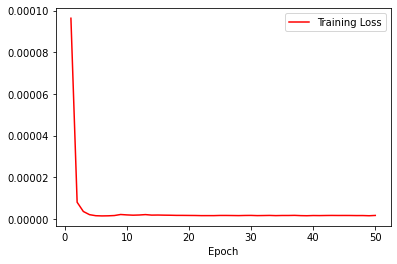

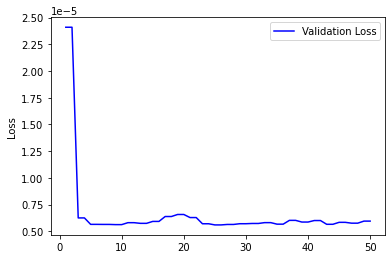

In [59]:
epoch_count = range(1, len(training_losses) + 1)
val_epoch_count = range(1, len(validation_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epoch_count, training_losses, 'r', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_epoch_count, validation_losses, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
torch.save(model.state_dict(), f=os.getcwd()+'/model.pt')